# Link Prediction in Condmat

In [186]:
import joblib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBClassifier

In [ ]:
edges = read_edges('out.sx-askubuntu', sep='\t')

In [2]:
print(f'Number of edges: {len(edges):.1e}')

Number of edges: 9.6e+05


## Set-up

### Random Split

In [22]:
starts = [70000*i for i in range(1, 11)]

In [27]:
edges_matures = [filter_edgelist(edges, start=start, stop=start+50000) for start in starts]

2011-07-19 07:09:41
2012-01-12 00:34:17
no_selected_edges=50000 (5.2e-02)
2012-03-07 23:47:19
2012-06-16 17:13:01
no_selected_edges=50000 (5.2e-02)
2012-07-24 01:51:04
2012-11-04 08:00:59
no_selected_edges=50000 (5.2e-02)
2012-12-16 21:33:22
2013-03-29 21:14:12
no_selected_edges=50000 (5.2e-02)
2013-05-10 18:27:25
2013-08-22 05:54:36
no_selected_edges=50000 (5.2e-02)
2013-10-02 19:06:12
2014-01-07 06:10:58
no_selected_edges=50000 (5.2e-02)
2014-02-11 00:37:16
2014-04-30 22:33:53
no_selected_edges=50000 (5.2e-02)
2014-05-30 02:35:12
2014-08-22 08:52:37
no_selected_edges=50000 (5.2e-02)
2014-09-27 21:40:40
2015-01-05 20:50:02
no_selected_edges=50000 (5.2e-02)
2015-02-13 03:45:27
2015-04-28 19:47:16
no_selected_edges=50000 (5.2e-02)


In [28]:
edges_probes = [filter_edgelist(edges, start=start+50000, stop=start+70000) for start in starts]

2012-01-12 00:34:18
2012-03-07 23:47:18
no_selected_edges=20000 (2.1e-02)
2012-06-16 17:13:02
2012-07-24 01:51:03
no_selected_edges=20000 (2.1e-02)
2012-11-04 08:01:00
2012-12-16 21:33:21
no_selected_edges=20000 (2.1e-02)
2013-03-29 21:14:13
2013-05-10 18:27:24
no_selected_edges=20000 (2.1e-02)
2013-08-22 05:54:37
2013-10-02 19:06:11
no_selected_edges=20000 (2.1e-02)
2014-01-07 06:10:59
2014-02-11 00:37:15
no_selected_edges=20000 (2.1e-02)
2014-04-30 22:33:54
2014-05-30 02:35:11
no_selected_edges=20000 (2.1e-02)
2014-08-22 08:52:38
2014-09-27 21:40:39
no_selected_edges=20000 (2.1e-02)
2015-01-05 20:50:03
2015-02-13 03:45:26
no_selected_edges=20000 (2.1e-02)
2015-04-28 19:47:17
2015-05-24 10:08:05
no_selected_edges=20000 (2.1e-02)


In [34]:
!mkdir random{0..9}

In [35]:
g_learns = [giant_component(get_graph(edges_mature)) for edges_mature in tqdm(edges_matures)]
uv_assessings = [convert_to_set(edges_probe) for edges_probe in tqdm(edges_probes)]

100%|██████████| 10/10 [00:00<00:00, 38.16it/s]


In [37]:
for index, g_learn in tqdm(enumerate(g_learns)): joblib.dump(g_learn, f'random{index}/graph.pkl', protocol=5) 
for index, uv_assessing in tqdm(enumerate(uv_assessings)): joblib.dump(uv_assessing, f'random{index}/probes.pkl', protocol=5)

10it [00:04,  2.02it/s]
10it [00:00, 12.35it/s]


In [38]:
for g_learn, uv_assessing in zip(g_learns, uv_assessings): report(graph=g_learn, probes=uv_assessing)

Number of probes: 14628
- already edge: 1097 (7%)
- both nodes in graph: 2306 (16%)
- not in graph: 9383 (64%)
Number of probes: 14042
- already edge: 893 (6%)
- both nodes in graph: 1755 (12%)
- not in graph: 9636 (69%)
Number of probes: 14647
- already edge: 729 (5%)
- both nodes in graph: 1646 (11%)
- not in graph: 10464 (71%)
Number of probes: 14205
- already edge: 752 (5%)
- both nodes in graph: 1434 (10%)
- not in graph: 10372 (73%)
Number of probes: 13977
- already edge: 717 (5%)
- both nodes in graph: 1310 (9%)
- not in graph: 10582 (76%)
Number of probes: 13472
- already edge: 746 (6%)
- both nodes in graph: 1083 (8%)
- not in graph: 10153 (75%)
Number of probes: 13452
- already edge: 880 (7%)
- both nodes in graph: 1203 (9%)
- not in graph: 9827 (73%)
Number of probes: 13169
- already edge: 742 (6%)
- both nodes in graph: 1248 (9%)
- not in graph: 9908 (75%)
Number of probes: 13134
- already edge: 733 (6%)
- both nodes in graph: 1088 (8%)
- not in graph: 9981 (76%)
Number of 

In [ ]:
for index, (g_learn, uv_assessing) in enumerate(zip(g_learns, uv_assessings)):
  nodepairs, _ = get_distances(g_learn, cutoff=2)
  targets = [nodepair in uv_assessing for nodepair in nodepairs]
  joblib.dump(nodepairs, f'random{index}/nodepairs.pkl', protocol=5) 
  joblib.dump(targets, f'random{index}/targets.pkl', protocol=5)
  print(f'{sum(targets) / len(nodepairs):e}')

### Temporal split

In [ ]:
edges_train_matures = [filter_edgelist(edges, start=start, stop=start+50000) for start in starts]
edges_train_probes = [filter_edgelist(edges, start=start+50000, stop=start+60000) for start in starts]
edges_test_matures = [filter_edgelist(edges, start=start, stop=start+60000) for start in starts]
edges_test_probes = [filter_edgelist(edges, start=start+60000, stop=start+70000) for start in starts]
!mkdir -p temporal{0..9}/{train,test}

In [ ]:
for index, (edges_mature, edges_probe) in enumerate(zip(edges_train_matures, edges_train_probes)):
  graph = giant_component(get_graph(edges_mature))
  probes = convert_to_set(edges_probe)
  nodepairs, _ = get_distances(graph, cutoff=2)
  targets = [nodepair in probes for nodepair in nodepairs]
  joblib.dump(graph,     f'temporal{index}/train/graph.pkl',     protocol=5) 
  joblib.dump(nodepairs, f'temporal{index}/train/nodepairs.pkl', protocol=5) 
  joblib.dump(targets,   f'temporal{index}/train/targets.pkl',   protocol=5)
  print(f'{sum(targets) / len(nodepairs):e}')

In [ ]:
for index, (edges_mature, edges_probe) in enumerate(zip(edges_test_matures, edges_test_probes)):
  graph = giant_component(get_graph(edges_mature))
  probes = convert_to_set(edges_probe)
  nodepairs, _ = get_distances(graph, cutoff=2)
  targets = [nodepair in probes for nodepair in nodepairs]
  joblib.dump(graph,     f'temporal{index}/test/graph.pkl',     protocol=5) 
  joblib.dump(nodepairs, f'temporal{index}/test/nodepairs.pkl', protocol=5) 
  joblib.dump(targets,   f'temporal{index}/test/targets.pkl',   protocol=5)
  print(f'{sum(targets) / len(nodepairs):e}')

## Hyperparameter selection

In [13]:
def get_x_y(df: pd.DataFrame): return df.drop(columns='target').values, df['target'].values
def report_performance(df_train: pd.DataFrame, df_test=None, random_state=1, max_depth=1, tree_method='hist', balanced=True, n_jobs=256):
    X, y = get_x_y(df_train)
    clf = XGBClassifier(max_depth=max_depth, n_jobs=n_jobs, tree_method=tree_method, scale_pos_weight=sum(~y)/sum(y) if balanced else 1 , random_state=random_state)
    if df_test is None: X, X_test, y, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)
    else: X_test, y_test = get_x_y(df_test)
    clf.fit(X, y)
    y_pred = clf.predict_proba(X_test)[:,1]
    return dict(ap_auc=average_precision_score(y_test, y_pred), ap=precision_recall_curve(y_test, y_pred))
def report(ls: list): return f"{np.mean(ls):.4f} +- {np.std(ls):.4f}"

In [5]:
random_split = [report_performance(pd.read_pickle(f'exp2/random-{i}.pkl'), max_depth=2, balanced=True) for i in tqdm(range(10))]


100%|██████████| 10/10 [03:59<00:00, 23.97s/it]


In [8]:
temporal_split = [
    report_performance(
        df_train=pd.read_pickle(f'exp2/temporal-train-{i}.pkl'), 
        df_test=pd.read_pickle(f'exp2/temporal-test-{i}.pkl'),
        max_depth=1, 
        balanced=True
    ) for i in tqdm(range(10))
]



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:25<12:51, 85.75s/it]

 20%|██        | 2/10 [01:53<09:06, 68.30s/it]

 30%|███       | 3/10 [02:23<06:37, 56.76s/it]

 40%|████      | 4/10 [03:44<06:24, 64.08s/it]

 50%|█████     | 5/10 [04:59<05:37, 67.44s/it]

 60%|██████    | 6/10 [06:25<04:52, 73.10s/it]

 70%|███████   | 7/10 [06:51<02:56, 58.78s/it]

 80%|████████  | 8/10 [07:16<01:37, 48.76s/it]

 90%|█████████ | 9/10 [07:42<00:42, 42.03s/it]

100%|██████████| 10/10 [09:06<00:00, 54.65s/it]


In [6]:
print(f"Random split: {report([result['ap_auc'] for result in random_split])}")
print(f"Temporal split: {report([result['ap_auc'] for result in temporal_split])}")

AP AUC: 0.025 +- 0.009
ROC AUC: 0.953 +- 0.010


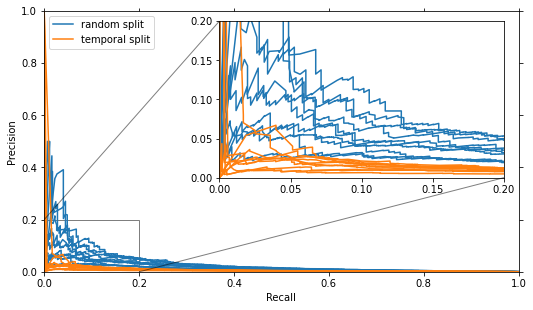

In [225]:
plt.figure(figsize=(8.5, 4.8))
ax = plt.axes(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
ax.tick_params(right=True, top=True)
# axins = inset_axes(
#     ax, width='100%', height='100%', bbox_to_anchor=(.31, .31, .67, .67), bbox_transform=ax.transAxes, axes_kwargs=
#     dict(xlabel='Recall', ylabel='Precision', xlim=(0, .2), ylim=(0, .2), xticks=np.arange(0, .21, .05), yticks=np.arange(0, .21, .05))
# )
# axins.tick_params(right=True, top=True)
axins = zoomed_inset_axes(ax, 3, bbox_to_anchor=(.31, .31, .67, .67), bbox_transform=ax.transAxes) 

for index, result in enumerate(random_split):
    precision, recall, thresholds = result['ap']
    mask = np.r_[True, np.diff(precision, 1) != 0] # Similar to drop_intermediate
    
    kwargs = dict(label='random split') if index == 0 else dict()
    ax.plot(   recall[mask], precision[mask], marker='', color=f'C0', ls='-', ms=2, **kwargs)
    axins.plot(recall[mask], precision[mask], marker='', color=f'C0', ls='-', ms=2, **kwargs)

for index, result in enumerate(temporal_split):
    precision, recall, thresholds = result['ap']
    mask = np.r_[True, np.diff(precision, 1) != 0] # Similar to drop_intermediate
    
    kwargs = dict(label='temporal split') if index == 0 else dict()
    ax.plot(   recall[mask], precision[mask], marker='', color=f'C1', ls='-', ms=2, **kwargs)
    axins.plot(recall[mask], precision[mask], marker='', color=f'C1', ls='-', ms=2, **kwargs)

axins.set_xlim((0, .2))
axins.set_ylim((0, .2))
axins.set_xticks(np.arange(0, .21, .05))
mark_inset(ax, axins, loc1=2, loc2=4, alpha=.5, lw=1)

ax.legend(loc='upper left')
plt.savefig('fig/exp2.jpg')   
plt.savefig('fig/exp2.pdf')

In [83]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes